# This notebook is for creting augmented dataset using imgaug for kaggle facial feature points detection 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import imgaug as ia

from tqdm import tqdm

loading original training dataset

In [2]:
org_training_file = "data/resized226.csv"
image_size = 226

df = pd.read_csv(org_training_file)
df['Image'] = df['Image'].apply(lambda im:np.fromstring(im, sep=' '))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

In [4]:
df.count()

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

In [5]:
df = df.dropna()
df.count()

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

X: Image  
y: feature points (teacher information)

In [6]:
X = np.vstack(df['Image'].values)
X = X.astype(np.float32)
X = X.reshape(X.shape[0], image_size, image_size)

y = df[df.columns[:-1]].values

In [7]:
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

# get keypoints
def get_kps(y_data):
    """
    param: y_data: annotations set
    """
    kps = []
    for i in range(len(y_data) // 2):
        kps.append(Keypoint(y_data[2 * i], y_data[2 * i + 1]))
    return kps


# convert an array to keypoints
def arr_to_kps(annotations):
    kpss = []
    for anno in annotations:
        kpss.append(get_kps(anno))
    return kpss

# gray scale image to rbg image
def gray_to_rgb(imgs):
    """
    param: imgs: (batch, height, width)
    """
    rgb_imgs = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], 3))
    for i in range(3):
        rgb_imgs[:, :, :, i] = imgs
    return rgb_imgs.astype('uint8')
        
# test
# kps = get_kps(y[0])
# kpsoi = KeypointsOnImage(kps, shape=X[0].shape)
# X_ = gray_to_rgb(X)
# ia.imshow(kpsoi.draw_on_image(X_[0], size=2))

In [20]:
X = gray_to_rgb(X)  # original image
y = arr_to_kps(y)  # keypoints

## Augmentation function

Now to the actual augmentation. We want to apply an affine transformation, which will alter both the image and the keypoints. We choose a bit of translation and rotation as our transoformation. Additionally, we add a bit of color jittering to the mix. That color jitter is only going to affect the image, not the keypoints.

In [19]:
import imgaug.augmenters as iaa
ia.seed(3)

seq = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (-0.05, 0.05), "y": (-0.15, 0.15)}),
    iaa.Affine(scale=(0.8, 1.0), rotate=(-30, 30), shear=(-15, 15)),
    iaa.PiecewiseAffine(scale=(0.01, 0.05))
    # iaa.Affine(translate_px={"x":(10, 30)}, rotate=(-10, 10)),
    # iaa.AddToHueAndSaturation((-50, 50))  #color jitter, only affects the image
])

In [29]:
aug_X = []
aug_y = []

AGM_RPT = 5  # 1 original image to AGM_RPT images

# It may takes few minutes
for j in range(AGM_RPT):
    for i in tqdm(range(X.shape[0])):
        aug_img, aug_kpsoi = seq(image=X[i], keypoints=y[i])
        aug_X.append(aug_img)
        aug_y.append(aug_kpsoi)

    

# img = ia.imresize_single_image(img.astype('uint8'), (96, 96))
# img_aug, kpsoi_aug = seq(image=img, keypoints=kpsoi)

100%|██████████| 2140/2140 [03:24<00:00, 10.49it/s]


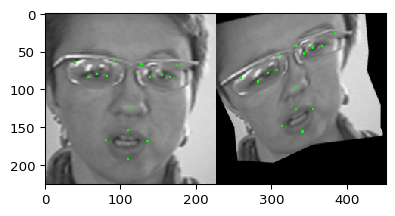

In [30]:
# check how transoformation worked !
id = 10

ia.imshow(
    np.hstack([
        KeypointsOnImage(y[id], shape=X[id].shape).draw_on_image(X[id], size=2),
        KeypointsOnImage(aug_y[id], shape=aug_X[id].shape).draw_on_image(aug_X[id], size=2)
    ])
)

In [31]:
## transformed images to save csv file
# new_X = []
# for img in aug_X:
#     new_X.append(img[:, :, 0])
# new_X = np.array(new_X).reshape(np.array(new_X).shape[0], -1)
# print(new_X.shape)

new_X = np.array(aug_X)[:, :, :, 0].reshape(len(aug_X), -1)
print(new_X.shape)

(10700, 51076)


In [32]:
# transformed annotations to save csv file
new_y = []
for anno in aug_y:
    new_y.append(KeypointsOnImage(anno, shape=X[0].shape).to_xy_array().reshape(-1))
new_y = np.array(new_y)
new_y.shape

(10700, 30)

In [33]:
columns = []
for col in df.columns:
    columns.append(col)

In [34]:
new_y_df = pd.DataFrame(data=new_y.astype('float64'), columns=columns[:-1])

In [36]:
new_X_df = pd.DataFrame([], columns=['Image'], index=range(len(new_X)))

for i in tqdm(range(len(new_X))):
    str_ = ""
    for j in range(new_X.shape[1]):
        str_ += "{} ".format(new_X[i, j])
    new_X_df.iloc[i, 0] = str_
    # new_X_df.iloc[i, 0] = np.array2string(new_X[i], separator=' ').replace("[", "").replace("]", "")

100%|██████████| 10700/10700 [04:13<00:00, 42.26it/s]


In [25]:
# np.fromstring(np.array2string(new_X[0], separator=' ').replace("[", "").replace("]", ""), sep=' ')
new_X_df.head()

,Image
0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [26]:
y_save_filename = "data/rotate_30.csv"

new_df = pd.concat([new_y_df, new_X_df], axis=1)
new_df.to_csv(y_save_filename, index=False)

In [27]:
new_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,147.0,74.0,68.0,102.0,133.0,82.0,162.0,69.0,81.0,97.0,...,140.0,155.0,175.0,89.0,200.0,114.0,177.0,122.0,202.0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,159.0,102.0,85.0,80.0,149.0,101.0,168.0,106.0,98.0,86.0,...,133.0,115.0,173.0,69.0,164.0,96.0,159.0,85.0,185.0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,134.0,79.0,78.0,95.0,125.0,84.0,145.0,79.0,90.0,94.0,...,122.0,158.0,140.0,110.0,162.0,133.0,146.0,139.0,160.0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,146.0,93.0,74.0,95.0,136.0,97.0,159.0,95.0,87.0,98.0,...,126.0,154.0,160.0,100.0,165.0,123.0,156.0,128.0,172.0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,156.0,117.0,104.0,85.0,144.0,112.0,164.0,121.0,110.0,93.0,...,134.0,101.0,170.0,47.0,141.0,75.0,148.0,63.0,174.0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


## Resize for imagenet  (only use once)

In [9]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Resize((226, 226)),
    iaa.Affine(rotate=(-30, 30))
])

In [10]:
X = gray_to_rgb(X)
y = arr_to_kps(y)
aug_X = []
aug_y = []
for i in range(X.shape[0]):
    aug_img, aug_kpsoi = seq(image=X[i], keypoints=y[i])
    aug_X.append(aug_img)
    aug_y.append(aug_kpsoi)

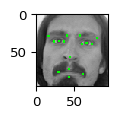

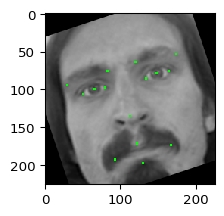

In [11]:
ia.imshow(KeypointsOnImage(y[0], shape=X[0].shape).draw_on_image(X[0], size=2))
ia.imshow(KeypointsOnImage(aug_y[0], shape=aug_X[0].shape).draw_on_image(aug_X[0], size=2))


In [12]:
new_X = []
for img in aug_X:
    new_X.append(img[:, :, 0])
new_X = np.array(new_X).reshape(np.array(new_X).shape[0], -1)
print(aug_X[0].shape)
print(new_X.shape)

(226, 226, 3)
(2140, 51076)


In [13]:
# transformed annotations to save csv file
new_y = []
for anno in aug_y:
    new_y.append(KeypointsOnImage(anno, shape=X[0].shape).to_xy_array().reshape(-1))
new_y = np.array(new_y)
new_y.shape

(2140, 30)

In [20]:
new_y[0]

array([146.70024 ,  79.28642 ,  64.816055, 100.20211 , 132.77379 ,
        85.53398 , 163.26947 ,  76.15987 ,  79.22533 ,  97.796196,
        50.409405, 107.410416, 118.995186,  63.79047 , 173.34938 ,
        53.58349 ,  81.620926,  76.18237 ,  28.79355 ,  95.408936,
       111.89458 , 135.73055 , 166.41982 , 174.3788  ,  91.73876 ,
       192.88976 , 121.24365 , 171.99316 , 129.44328 , 197.92229 ],
      dtype=float32)

In [14]:
columns = []
for col in df.columns:
    columns.append(col)

In [15]:
new_y_df = pd.DataFrame(data=new_y.astype('float64'), columns=columns[:-1])

In [16]:
new_X_df = pd.DataFrame([], columns=['Image'], index=range(len(new_X)))

for i in range(len(new_X)):
    str_ = ""
    for j in range(new_X.shape[1]):
        str_ += "{} ".format(new_X[i, j])
    new_X_df.iloc[i, 0] = str_
    # new_X_df.iloc[i, 0] = np.array2string(new_X[i], separator=' ').replace("[", "").replace("]", "")

In [17]:
new_df = pd.concat([new_y_df, new_X_df], axis=1)
new_df.to_csv('data/resized226_rotate_30.csv', index=False)

## shifting keypoints

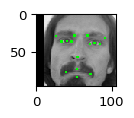

In [59]:
img_pad = ia.pad(img, left=10)
kpsoi_pad = kpsoi.shift(x=10)
ia.imshow(kpsoi_pad.draw_on_image(img_pad, size=2))

In [66]:
arr = kpsoi.to_xy_array()
print(arr.shape)
print(arr)
print(arr.reshape(-1))

(15, 2)
[[66.03356  39.002274]
 [30.227007 36.421677]
 [59.582077 39.647423]
 [73.13035  39.969997]
 [36.35657  37.3894  ]
 [23.452871 37.3894  ]
 [56.953262 29.033648]
 [80.22713  32.228138]
 [40.227608 29.002321]
 [16.356379 29.64747 ]
 [44.42057  57.066803]
 [61.19531  79.97017 ]
 [28.614496 77.38899 ]
 [43.312603 72.935455]
 [43.130707 84.48577 ]]
[66.03356  39.002274 30.227007 36.421677 59.582077 39.647423 73.13035
 39.969997 36.35657  37.3894   23.452871 37.3894   56.953262 29.033648
 80.22713  32.228138 40.227608 29.002321 16.356379 29.64747  44.42057
 57.066803 61.19531  79.97017  28.614496 77.38899  43.312603 72.935455
 43.130707 84.48577 ]
